# Podcast Listening Time Prediction

## 1. Setup and Imports

In [99]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Machine Learning - Models
import xgboost as xgb
from xgboost import XGBRegressor

# Utilities
import gc

In [100]:
# Load datasets
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_sub = pd.read_csv('data/sample_submission.csv')

print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (750000, 12)
Test data shape: (250000, 11)


## 2. Data Loading

In [101]:
# Display first few rows of training data
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [102]:
# Statistical summary of numerical features
df_train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [103]:
df_test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [104]:
df_sub.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [105]:
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)


## 3. Exploratory Data Analysis

In [106]:
df_train.shape,df_test.shape

((750000, 11), (250000, 10))

In [107]:
# Check for missing values in training data
missing_train = df_train.isnull().sum()
print("Missing values in training data:")
print(missing_train[missing_train > 0])

Missing values in training data:
Episode_Length_minutes          87093
Guest_Popularity_percentage    146030
Number_of_Ads                       1
dtype: int64


In [108]:
# Check for missing values in test data
missing_test = df_test.isnull().sum()
print("Missing values in test data:")
print(missing_test[missing_test > 0])

Missing values in test data:
Episode_Length_minutes         28736
Guest_Popularity_percentage    48832
dtype: int64


In [109]:
df_train.shape,df_test.shape,df_sub.shape

((750000, 11), (250000, 10), (250000, 2))

In [110]:
# Correlation matrix for numerical features
correlation_matrix = df_train.corr(numeric_only=True)
print("Correlation with target variable (Listening_Time_minutes):")
print(correlation_matrix['Listening_Time_minutes'].sort_values(ascending=False))

Correlation with target variable (Listening_Time_minutes):
Listening_Time_minutes         1.000000
Episode_Length_minutes         0.916749
Host_Popularity_percentage     0.050870
Guest_Popularity_percentage   -0.016014
Number_of_Ads                 -0.118337
Name: Listening_Time_minutes, dtype: float64


In [111]:
df_train.dtypes

Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

## 4. Data Preprocessing

In [ ]:

# XGBoost parameters
cross_validation_params = {
    'n_estimators': 565,              # Number of trees
    'max_depth': 18,                  # Maximum tree depth
    'learning_rate': 0.04222221,      # Step size shrinkage
    'subsample': 0.8,                 # Fraction of samples for each tree
    'colsample_bytree': 0.8,          # Fraction of features for each tree
    'random_state': 42,               # For reproducibility
    'early_stopping_rounds': 100,     # Stop if no improvement for 100 rounds
    'tree_method': 'hist',            # Fast histogram algorithm
    'n_jobs': -1                      # Use all CPU cores
}

In [ ]:
# Reload data for preprocessing
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Save test IDs for submission
test_ids = df_test['id'].copy()

# Remove ID columns (not useful for prediction)
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

# Separate features and target
y = df_train['Listening_Time_minutes']
X = df_train.drop(columns=['Listening_Time_minutes'])
X_test = df_test.copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test set shape: {X_test.shape}")


Features shape: (750000, 10)
Target shape: (750000,)
Test set shape: (250000, 10)


### 4.1 Handle Missing Values

In [113]:
# Fill missing values for numerical columns with median
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
X_test[numerical_cols] = X_test[numerical_cols].fillna(X[numerical_cols].median())

print("Missing values handled for numerical columns")

Missing values handled for numerical columns


### 4.2 Encode Categorical Variables

In [114]:
# Encode categorical columns using Label Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {list(categorical_cols)}")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to ensure consistency between train and test
    combined = pd.concat([X[col], X_test[col]], axis=0)
    le.fit(combined.astype(str))
    
    # Transform both datasets
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"All categorical columns encoded successfully")
print(f"Final features shape: {X.shape}")

Categorical columns to encode: ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
All categorical columns encoded successfully
Final features shape: (750000, 10)


In [115]:
# Verify that all columns are now numeric
print("Data type verification:")
print(f"Number of object columns in X: {X.select_dtypes(include=['object']).shape[1]}")
print(f"All features are numeric: {X.select_dtypes(include=['object']).shape[1] == 0}")
print("\nFeature data types:")
print(X.dtypes)

Data type verification:
Number of object columns in X: 0
All features are numeric: True

Feature data types:
Podcast_Name                     int64
Episode_Title                    int64
Episode_Length_minutes         float64
Genre                            int64
Host_Popularity_percentage     float64
Publication_Day                  int64
Publication_Time                 int64
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment                int64
dtype: object


## 5. Model Training and Evaluation

In [122]:
# Define RMSE metric
def rmse(y_true, y_pred):
    """Calculate Root Mean Square Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cross-validation setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tracking variables
scores = []
test_preds = np.zeros(len(X_test))

print("cross-validation training started")
print("-" * 40)

# Train model with cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nTraining fold {fold + 1}/{n_splits}...")
    
    # Split data for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train XGBoost model
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    # Make predictions
    val_pred = model.predict(X_val)
    score = rmse(y_val, val_pred)
    scores.append(score)
    
    # Accumulate test predictions
    test_preds += model.predict(X_test) / n_splits
    
    print(f"Fold {fold + 1} RMSE: {score:.4f}")

# Display final results
print("\n" + "=" * 40)
print("RESULTS")
print("=" * 40)
print(f"Mean RMSE: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
print("=" * 40)
print(f"Best fold RMSE: {np.min(scores):.4f}")
print(f"Worst fold RMSE: {np.max(scores):.4f}")

cross-validation training started
----------------------------------------
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

Training fold 1/5...
[0]	validation_0-rmse:26.26073
[100]	validation_0-rmse:12.75972
[200]	validation_0-rmse:12.64646
[300]	validation_0-rmse:12.62835
[400]	validation_0-rmse:12.62862
[430]	validation_0-rmse:12.62889
Fold 1 RMSE: 12.6275

Training fold 2/5...
[0]	validation_0-rmse:26.29161
[100]	validation_0-rmse:12.78424
[200]	validation_0-rmse:12.66988
[300]	validation_0-rmse:12.65396
[400]	validation_0-rmse:12.65273
[449]	validation_0-rmse:12.65316
Fold 2 RMSE: 12.6514

Training fold 3/5...
[0]	validation_0-rmse:26.26286
[100]	validation_0-rmse:12.78406
[200]	validation_0-rmse:12.66975
[300]	validation_0-rmse:12.65239
[400]	validation_0-rmse:12.65342
[406]	validation_0-rmse:12.65353
Fold 3 RMSE: 12.6522

Training fold 4/5...
[0]	validation_0-rmse:26.32260
[100]	val

## 6. Model Analysis and Visualization

/var/folders/5y/3k771h3n08vgfqcjl7vts2yh0000gn/T/ipykernel_65429/4226515958.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


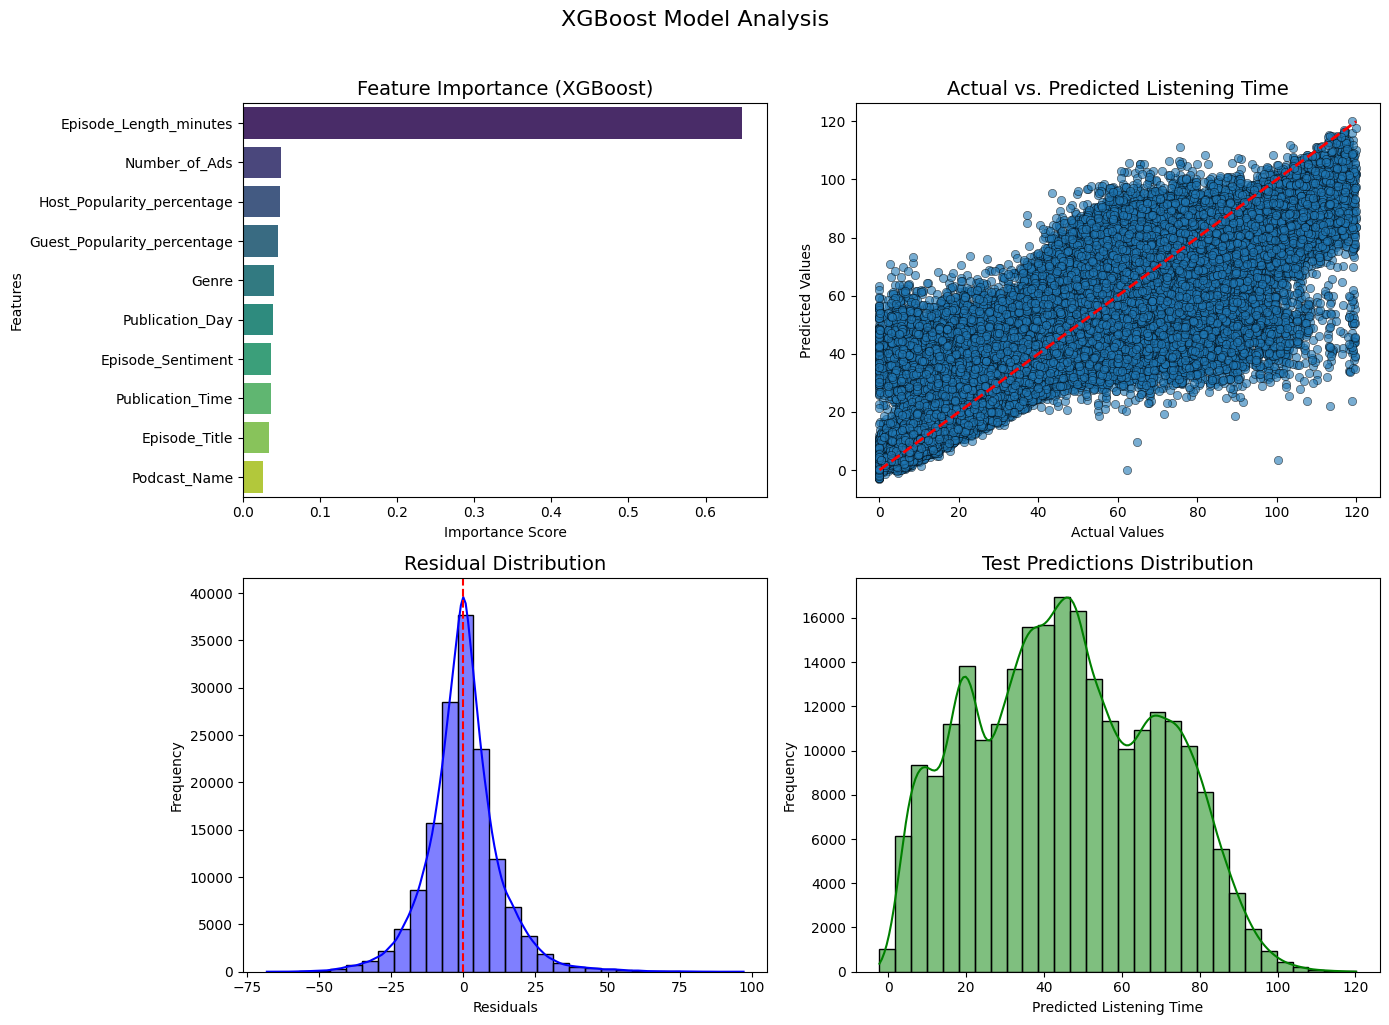

In [123]:
# Create comprehensive visualization of model results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature Importance Plot
feature_importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

sns.barplot(
    x="Importance", y="Feature",
    data=importance_df,
    palette="viridis",
    ax=axes[0, 0]
)
axes[0, 0].set_title("Feature Importance (XGBoost)", fontsize=14)
axes[0, 0].set_xlabel("Importance Score")
axes[0, 0].set_ylabel("Features")

# 2. Actual vs Predicted Values
sns.scatterplot(
    x=y_val, y=val_pred,
    alpha=0.6, edgecolors="k",
    ax=axes[0, 1]
)
axes[0, 1].plot(
    [min(y_val), max(y_val)],
    [min(y_val), max(y_val)],
    '--r', linewidth=2
)
axes[0, 1].set_title("Actual vs. Predicted Listening Time", fontsize=14)
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].set_ylabel("Predicted Values")

# 3. Residual Distribution
residuals = y_val - val_pred
sns.histplot(
    residuals, bins=30, kde=True,
    color='blue', ax=axes[1, 0]
)
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residual Distribution", fontsize=14)
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")

# 4. Test Predictions Distribution
sns.histplot(
    test_preds, bins=30, kde=True,
    color='green', ax=axes[1, 1]
)
axes[1, 1].set_title("Test Predictions Distribution", fontsize=14)
axes[1, 1].set_xlabel("Predicted Listening Time")
axes[1, 1].set_ylabel("Frequency")

plt.suptitle("XGBoost Model Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 7. Generate Submission File

In [124]:
# Create submission dataframe with test IDs and predictions
df_sub = pd.DataFrame({
    'id': test_ids,
    'Listening_Time_minutes': test_preds
})

print("Submission dataframe created")
print(f"Shape: {df_sub.shape}")

Submission dataframe created
Shape: (250000, 2)


In [125]:
# Save submission to CSV file
df_sub.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [126]:
# Display first few rows of submission
print("Submission preview:")
df_sub.head(10)

Submission preview:


,id,Listening_Time_minutes
0,750000,53.049703
1,750001,22.837829
2,750002,48.403626
3,750003,75.056527
4,750004,44.253928
5,750005,22.697087
6,750006,83.902739
7,750007,41.726347
8,750008,63.107463
9,750009,77.325429


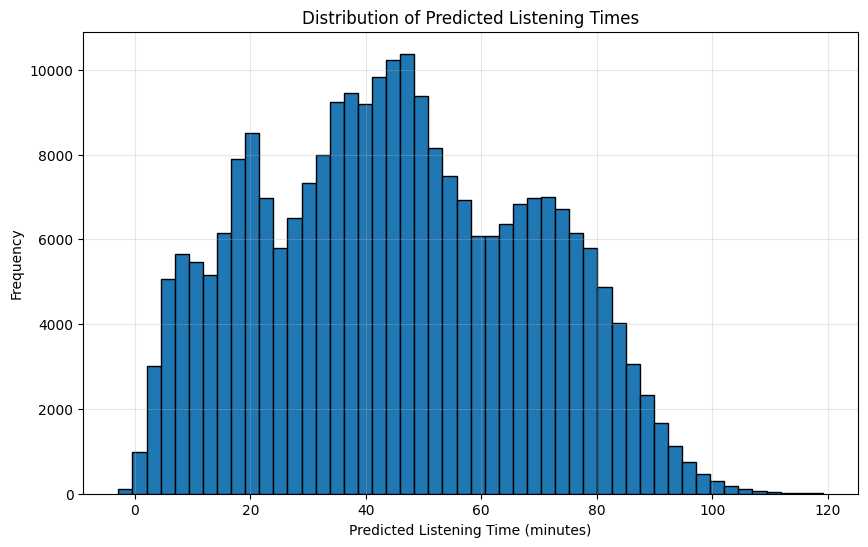


Prediction Statistics:
count    250000.000000
mean         45.416496
std          23.305263
min          -2.848530
25%          27.104366
50%          44.627358
75%          63.980304
max         119.174847
Name: Listening_Time_minutes, dtype: float64


In [121]:
# Visualize distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(df_sub['Listening_Time_minutes'], bins=50, edgecolor='black')
plt.xlabel('Predicted Listening Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Listening Times')
plt.grid(True, alpha=0.3)
plt.show()

# Summary statistics
print("\nPrediction Statistics:")
print(df_sub['Listening_Time_minutes'].describe())